In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import make_scorer,mean_absolute_error, mean_squared_error

from sklearn.ensemble import StackingRegressor, RandomForestRegressor


from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression, RidgeCV,SGDRegressor, LassoCV
from sklearn.svm import SVR

from sklearn.compose import make_column_transformer,make_column_selector

#import pr affichage visuel d'un pipeline
from sklearn import set_config
set_config(display='diagram')

# Pre processing

In [2]:
df=pd.read_csv('Kaggle/train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

<AxesSubplot:>

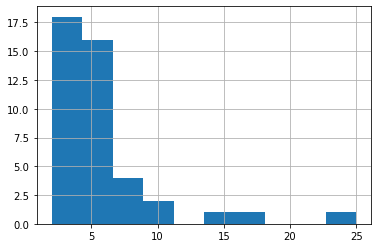

In [6]:
df.select_dtypes(include=['object']).nunique().hist()

In [7]:
df=df.drop(['Id'],axis=1)

In [8]:
X=df.drop(['SalePrice'],axis=1)
y=df['SalePrice']

In [9]:
X.shape

(1460, 79)

## Features selection based on number of missing values

In [10]:
for column in X.columns.values:
    if (X[column].isna().any() ==True): 
        print(f'la colonne {column} a : ')
        print(X[column].isna().value_counts())
        print('*********************************')

la colonne LotFrontage a : 
False    1201
True      259
Name: LotFrontage, dtype: int64
*********************************
la colonne Alley a : 
True     1369
False      91
Name: Alley, dtype: int64
*********************************
la colonne MasVnrType a : 
False    1452
True        8
Name: MasVnrType, dtype: int64
*********************************
la colonne MasVnrArea a : 
False    1452
True        8
Name: MasVnrArea, dtype: int64
*********************************
la colonne BsmtQual a : 
False    1423
True       37
Name: BsmtQual, dtype: int64
*********************************
la colonne BsmtCond a : 
False    1423
True       37
Name: BsmtCond, dtype: int64
*********************************
la colonne BsmtExposure a : 
False    1422
True       38
Name: BsmtExposure, dtype: int64
*********************************
la colonne BsmtFinType1 a : 
False    1423
True       37
Name: BsmtFinType1, dtype: int64
*********************************
la colonne BsmtFinType2 a : 
False    1422
True 

In [11]:
X.shape

(1460, 79)

## Data preparation of categorial features

In [12]:
X.select_dtypes(include=['object']).nunique() 

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [13]:
many_cat=pd.DataFrame(X.select_dtypes(include=['object']).nunique() > 10)
many_cat=list(many_cat[many_cat[0]==True].index)

In [14]:
many_cat

['Neighborhood', 'Exterior1st', 'Exterior2nd']

### Ordinal _ non ordinal

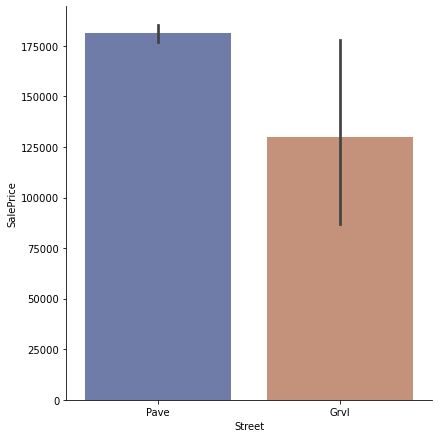

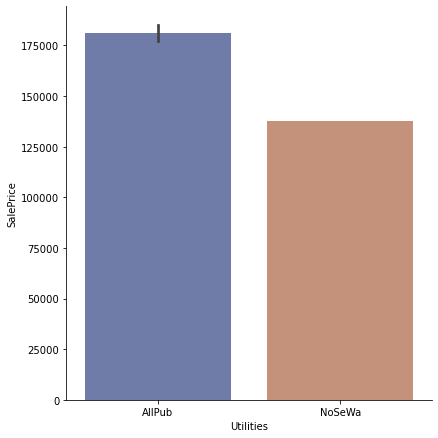

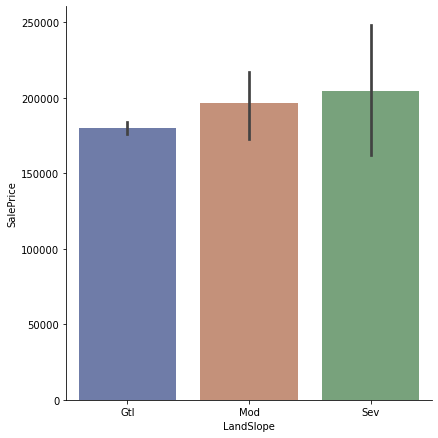

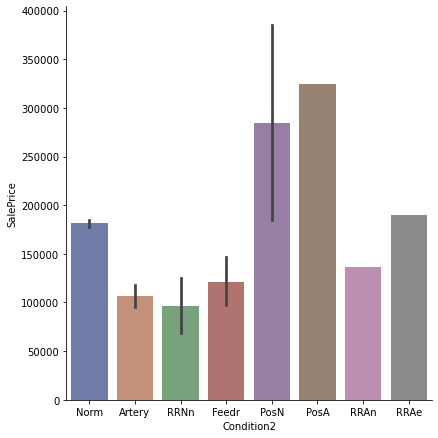

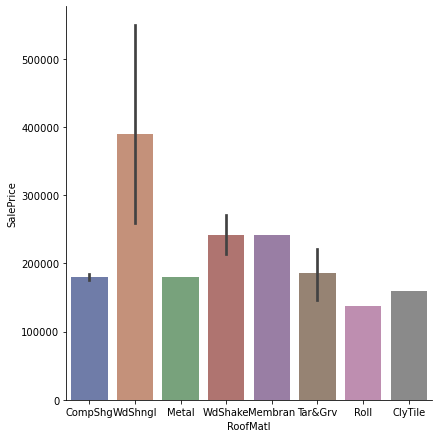

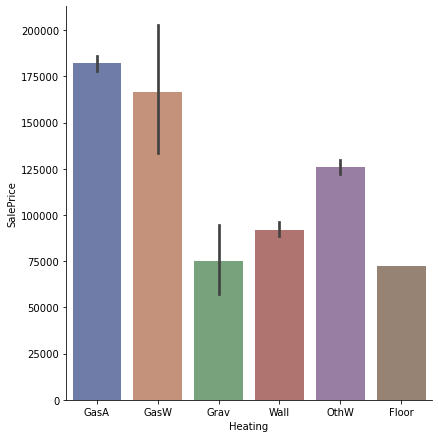

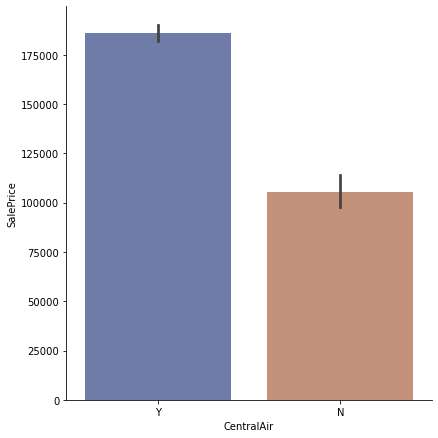

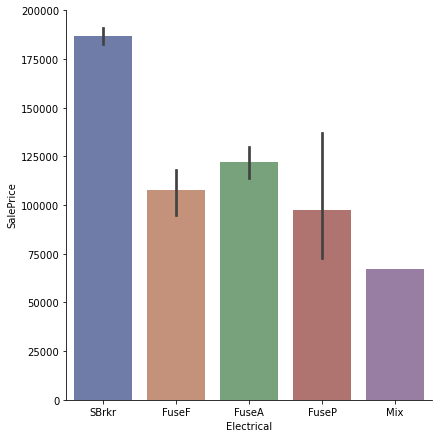

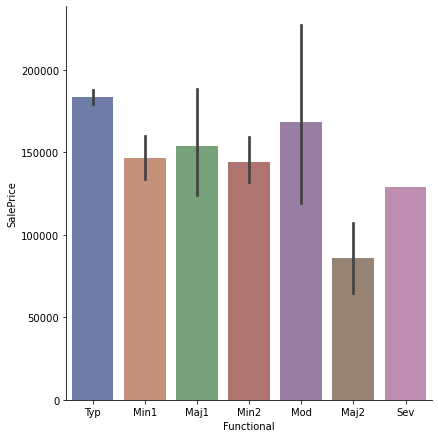

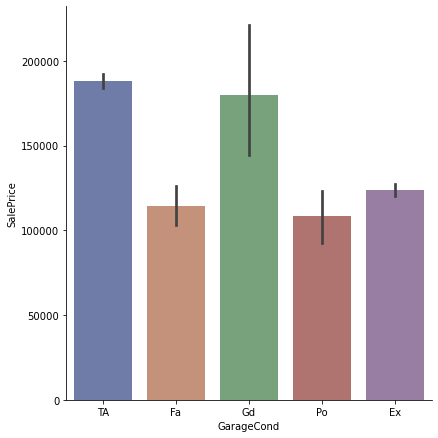

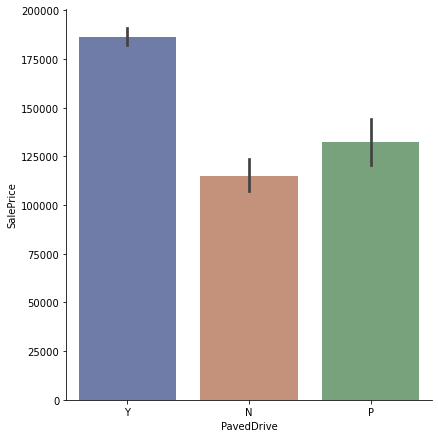

In [15]:
for column in X.select_dtypes(include=['object']):
    if (X[column].value_counts()[0]/X.shape[0])*100>90 :
        sns.catplot(
            data=df, kind="bar",
            x=column, y="SalePrice",
            palette="dark", alpha=.6, height=6)

In [16]:
X.select_dtypes(include=['object']).columns.values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

### Drop some features

In [17]:
indexNames = X[(X['LotArea'] > 100000) |
                (X['MiscVal']>6000)|
                (X['3SsnPorch']>350) |
                (X['EnclosedPorch']>400) |
                (X['OpenPorchSF']>450) |
                (X['1stFlrSF']>4000) |
                (X['TotalBsmtSF']>5000) |
                (X['BsmtFinSF2']>1200) |
                (X['BsmtFinSF1']>5000) |
                (X['LotFrontage']>250) |
                (X['GrLivArea']>4700)].index
#X=X.drop(indexNames)
X.shape

(1460, 79)

In [18]:
X=X.drop(['Exterior2nd','BsmtFinType2','Condition2','FireplaceQu','MiscFeature'],axis=1)

In [19]:
# version avec toutes les catégories 
ordinal_features = ['Street','Alley','Neighborhood','Condition1','Condition2','Exterior1st', 'ExterQual', 
                    'ExterCond','BsmtQual','BsmtCond','BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2','HeatingQC','KitchenQual',
                    'GarageQual','GarageCond','PoolQC','Fence']

non_ordinal_features =['MSZoning', 'LotShape','LandContour','Utilities','LotConfig',
                       'LandSlope','BldgType','HouseStyle', 'RoofStyle', 'RoofMatl',
                       'MasVnrType','Foundation','Heating','CentralAir', 'Electrical',
                       'Functional','GarageType', 'GarageFinish','PavedDrive', 'SaleType', 'SaleCondition']

numerical_features= X.select_dtypes(include=[np.number]).columns.values

In [20]:
#version avec un équilibrage en faveur des catégories non ordinal
ordinal_features = ['Street','Alley','Neighborhood','Exterior1st', 'ExterQual', 
                    'ExterCond','BsmtQual','BsmtCond','BsmtExposure',
                    'HeatingQC','KitchenQual','GarageQual','GarageCond','PoolQC']

non_ordinal_features =['MSZoning', 'LotShape','LandContour','Utilities','LotConfig',
                       'Condition1',
                       'LandSlope','BldgType','HouseStyle', 'RoofStyle', 'RoofMatl',
                       'BsmtFinType1', 'MasVnrArea',
                       'MasVnrType','Foundation','Heating','CentralAir', 'Electrical','Functional','GarageType',
                       'GarageFinish','PavedDrive', 'SaleType', 
                       'Fence']
numerical_features= X.select_dtypes(include=[np.number]).columns.values

#### Ordinal Cat

In [21]:
list_ordinal=[]
for column in df[ordinal_features[0:4]]:
    encoted_column=df[[column,'SalePrice']].groupby([column],as_index=False).mean()
    encoted_column =encoted_column.sort_values(by='SalePrice')
    encoted_column =encoted_column.reset_index(drop=True)
    if len(df[column].isnull().value_counts())!=1 :
        list_ordinal.append(['No']+list(encoted_column[column]))
    else :
        list_ordinal.append(list(encoted_column[column]))
list_ordinal[0:2]

[['Grvl', 'Pave'], ['No', 'Grvl', 'Pave']]

In [22]:
list_ExterQual=['Po','Fa','TA','Gd','Ex']
list_ExterCond=['Po','Fa','TA','Gd','Ex']
list_BsmtQual=['No','Po','Fa','TA','Gd','Ex']
list_BsmtCond=['No','Po','Fa','TA','Gd','Ex']
list_BsmtExposure=['No','Mn','Av','Gd']
#list_BsmtFinType1=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
#list_BsmtFinType2=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
list_HeatingQC=['Po','Fa','TA','Gd','Ex']
list_KitchenQual=['Po','Fa','TA','Gd','Ex']
#list_FireplaceQu=['No','Po','Fa','TA','Gd','Ex']
list_GarageQual= ['No','Po','Fa','TA','Gd','Ex']
list_GarageCond= ['No','Po','Fa','TA','Gd','Ex']
list_PoolQC=['No','Fa','TA','Gd','Ex']
#list_Fence=['No','MnWw','GdWo','MnPrv','GdPrv']

In [23]:
#list_cat_ord_lists=[list_ExterQual,list_ExterCond,list_BsmtQual,list_BsmtCond,list_BsmtExposure,list_BsmtFinType1,
#                    list_BsmtFinType2,list_HeatingQC,list_KitchenQual,
#                    list_GarageQual,list_GarageCond,list_PoolQC,list_Fence]

In [24]:
list_cat_ord_lists=[list_ExterQual,list_ExterCond,list_BsmtQual,list_BsmtCond,list_BsmtExposure,
                    list_HeatingQC,list_KitchenQual,
                    list_GarageQual,list_GarageCond,list_PoolQC]

In [25]:
for list in list_cat_ord_lists:
    list_ordinal.append(list)

#### Encodage manuel  de SaleCondition

In [26]:
X[['SaleCondition']].value_counts()

SaleCondition
Normal           1198
Partial           125
Abnorml           101
Family             20
Alloca             12
AdjLand             4
dtype: int64

In [27]:
encoted_column=df[['SaleCondition','SalePrice']].groupby(['SaleCondition'],as_index=False).mean()
encoted_column =encoted_column.sort_values(by='SalePrice')
encoted_column

,SaleCondition,SalePrice
1,AdjLand,104125.000000
0,Abnorml,146526.623762
3,Family,149600.000000
2,Alloca,167377.416667
4,Normal,175202.219533
5,Partial,272291.752000


In [28]:
i=0
for value in X['SaleCondition']:
    if value == 'Normal':
        X.at[i,"SaleCondition"]=2
    else:
        X.at[i,"SaleCondition"]=0
    i+=1

In [29]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,2,2008,WD,2
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,NaN,0,5,2007,WD,2
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,9,2008,WD,2
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,NaN,0,2,2006,WD,0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,NaN,0,12,2008,WD,2


#### Non ord Cat

In [30]:
X[non_ordinal_features].head()

,MSZoning,LotShape,LandContour,Utilities,LotConfig,Condition1,LandSlope,BldgType,HouseStyle,RoofStyle,...,Foundation,Heating,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,SaleType,Fence
0,RL,Reg,Lvl,AllPub,Inside,Norm,Gtl,1Fam,2Story,Gable,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,NaN
1,RL,Reg,Lvl,AllPub,FR2,Feedr,Gtl,1Fam,1Story,Gable,...,CBlock,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,NaN
2,RL,IR1,Lvl,AllPub,Inside,Norm,Gtl,1Fam,2Story,Gable,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,NaN
3,RL,IR1,Lvl,AllPub,Corner,Norm,Gtl,1Fam,2Story,Gable,...,BrkTil,GasA,Y,SBrkr,Typ,Detchd,Unf,Y,WD,NaN
4,RL,IR1,Lvl,AllPub,FR2,Norm,Gtl,1Fam,2Story,Gable,...,PConc,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,NaN


### Gestion des numerical features

In [31]:
num_cols = df.select_dtypes(include=np.number)

In [32]:
num_cols.shape

(1460, 37)

In [33]:
corr = num_cols.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:19], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-19:])

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64 

OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.1359

In [34]:
corr['SalePrice'].sort_values(ascending=False)[-9:].index.values

array(['BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold',
       'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr'],
      dtype=object)

In [35]:
X=X.drop(corr['SalePrice'].sort_values(ascending=False)[-10:].index.values, axis=1)

In [36]:
numerical_features= X.select_dtypes(include=[np.number]).columns.values

In [37]:
def calculatevif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('Supprime cette feature '' + X[cols[variables]].columns[maxloc] + '' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Garde ces variables:')
    print(X.columns[variables])
    return X[cols[variables]]

## Pipeline & model
### Feature percentile

In [38]:
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [39]:
#X.head()

In [40]:
#avec Knn
non_ord_pipe= Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("ohe",OneHotEncoder(handle_unknown="ignore"))
                       ])
ord_pipe= Pipeline([("imputer", SimpleImputer(strategy="constant",fill_value='No')),
                        ("ord",OrdinalEncoder(categories=list_ordinal,handle_unknown="use_encoded_value",
                                              unknown_value=-1 ))
                       ])
num_pipe= Pipeline([("imputer", SimpleImputer(strategy='median')),
                    ("scaler",StandardScaler())
                   ])

In [41]:
preprocessing= make_column_transformer((non_ord_pipe,non_ordinal_features),
                                       (ord_pipe,ordinal_features),
                                       (num_pipe,numerical_features))

In [42]:
#model_1=Pipeline([("preprocessing",preprocessing),
                #("SelectPercentile",SelectPercentile(chi2, percentile=10)),
#                ("LR",LassoCV())])
#model_2=Pipeline([("preprocessing",preprocessing),
#                #("SelectPercentile",SelectPercentile(chi2, percentile=10)),
#                ("LR",LinearRegression())])
#model_3=Pipeline([("preprocessing",preprocessing),
#                #("SelectPercentile",SelectPercentile(chi2, percentile=10)),
#                ("LR",RidgeCV())])

In [43]:
model_1=LassoCV()
model_2=LinearRegression()
model_3=RidgeCV()
model_4=SVR()
model_5=RandomForestRegressor()

In [61]:
model = Pipeline([("preprocessing",preprocessing),("stacking",StackingRegressor([('Lasso', model_1),
                        ('LR', model_2),
                        ('Ridge', model_3),
                        ('SVM', model_4),
                        ('RandomForest',model_5)],
                        final_estimator=RandomForestRegressor()))])

#model.fit(X, y)
#model.score(X_test, y_test)

In [62]:
def custom_metrics(y_test,y_predicted):
    return mean_squared_error(np.log(y_test), np.log(y_predicted), squared=False)

In [ ]:
score=make_scorer(custom_metrics, greater_is_better=False)

scores = cross_val_score( model, X, y, cv=5, scoring=score, error_score="raise")
scores.mean()

In [ ]:
model.fit(X,y)

In [ ]:
y_predicted=model.predict(X)

In [ ]:
from math import sqrt
rms = sqrt(mean_squared_error(np.log(y), np.log(y_predicted)))

rms


In [ ]:
df_test=pd.read_csv('Kaggle/test.csv')

In [51]:
X.columns.values

array(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch',
       'PoolArea', 'PoolQC', 'Fence', 'MoSold', 'SaleType',
       'SaleCondition'], dtype=object)

In [52]:
test_set=df_test[X.columns.values]

In [53]:
i=0
for value in test_set['SaleCondition']:
    if value == 'Normal':
        test_set.at[i,"SaleCondition"]=2
    else:
        test_set.at[i,"SaleCondition"]=0
    i+=1

In [54]:
result=model.predict(test_set)

In [55]:
result=pd.DataFrame(result)

In [56]:
result['Id']=df_test['Id']

In [57]:
result=result.rename(columns={0: "SalePrice"})

In [58]:
result=result[['Id','SalePrice']]

In [59]:
result

,Id,SalePrice
0,1461,162738.008490
1,1462,163064.492203
2,1463,163193.056583
3,1464,163243.271538
4,1465,163423.158115
...,...,...
1454,2915,162864.663200
1455,2916,162849.589101
1456,2917,163049.023959
1457,2918,162749.086563


In [60]:
result.to_csv('resultat.csv',index=False)